# 코랩 연결

In [ ]:
# google drive와 colab연동
from google.colab import auth

auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# 함수 호출

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn import preprocessing, metrics
from ipywidgets import widgets, interactive
import gc
import joblib
import warnings

warnings.filterwarnings('ignore')
from datetime import datetime, timedelta 
from typing import Union
from tqdm.notebook import tqdm_notebook as tqdm
from itertools import cycle
import datetime as dt
from torch.autograd import Variable
import random 
import os
from matplotlib.pyplot import figure
from fastprogress import master_bar, progress_bar
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import time 
from torch.utils.data import Dataset,DataLoader,TensorDataset
from sklearn.metrics import mean_squared_error
import torch 

%matplotlib inline


pd.set_option('max_columns', 100)
plt.style.use('bmh')

color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

# GPU 및 SEED 고정

In [ ]:
# torch GPU 사용 여부
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device is:",device)

SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(SEED)

device is: cuda


# 데이터 불러오기

In [ ]:
path = "./gdrive/My Drive/dacon/발전량/data/"

train_df = pd.read_csv(path+'./train/train.csv')
sub_df = pd.read_csv(path+'./sample_submission.csv')

test_df = pd.DataFrame()
test_set_df = pd.DataFrame()

for i in tqdm(os.listdir(path+'/test/')):
  df = pd.read_csv(path+"/test/"+i)
  df["F_NAME"] = "TEST_"+i
  test_df = pd.concat([test_df,df],axis=0)
  test_set_df = pd.concat([test_set_df,df[df["Day"]>=5]],axis=0)

  del df

test_df = test_df.reset_index(drop=True)
test_set_df = test_set_df.reset_index(drop=True)


test_df["TY"] = test_df["F_NAME"].apply(lambda x:x[x.find("_")+1:x.find(".")])
test_df["TY"] = test_df["TY"].astype('int')
test_df.sort_values(by=["TY","Day","Hour","Minute"],inplace=True)
test_df = test_df.reset_index(drop=True)

test_set_df["TY"] = test_set_df["F_NAME"].apply(lambda x:x[x.find("_")+1:x.find(".")])
test_set_df["TY"] = test_set_df["TY"].astype('int')
test_set_df.sort_values(by=["TY","Day","Hour","Minute"],inplace=True)
test_set_df = test_set_df.reset_index(drop=True)

In [ ]:
print(train_df.shape)
train_df.head()

(52560, 9)


,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
0,0,0,0,0,0,1.5,69.08,-12,0.0
1,0,0,30,0,0,1.5,69.06,-12,0.0
2,0,1,0,0,0,1.6,71.78,-12,0.0
3,0,1,30,0,0,1.6,71.75,-12,0.0
4,0,2,0,0,0,1.6,75.20,-12,0.0


In [ ]:
print(test_df.shape)
test_df.head()

(27216, 11)


,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,F_NAME,TY
0,0,0,0,0,0,2.7,34.42,0.0,0.0,TEST_0.csv,0
1,0,0,30,0,0,2.7,34.17,0.1,0.0,TEST_0.csv,0
2,0,1,0,0,0,2.7,34.23,0.2,0.0,TEST_0.csv,0
3,0,1,30,0,0,2.7,33.99,0.3,0.0,TEST_0.csv,0
4,0,2,0,0,0,2.8,33.97,0.4,0.0,TEST_0.csv,0


# TS 살펴보기

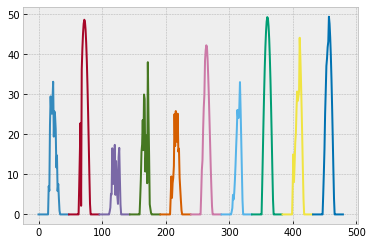

In [ ]:
# FRQ = 30
for i in range(10):
  train_df[train_df["Day"] == i]["TARGET"].plot()

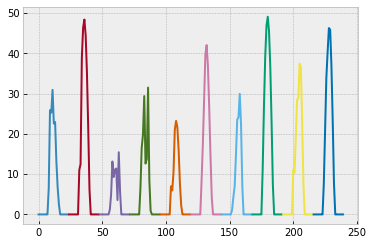

In [ ]:
# FRQ = 60
p_df = train_df.groupby(["Day","Hour"])["TARGET"].mean().reset_index()

for i in range(10):
  p_df[p_df["Day"] == i]["TARGET"].plot()

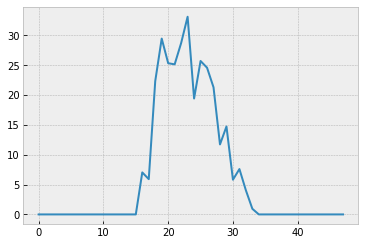

In [ ]:
train_df[train_df["Day"] == 0]["TARGET"].plot()

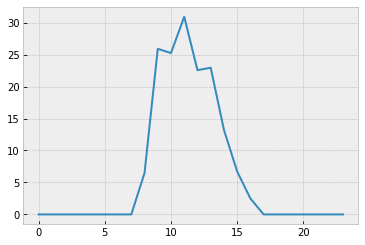

In [ ]:
p_df[p_df["Day"] == 0]["TARGET"].plot()

# 최근 1년 데이터만 학습

In [ ]:
train_df = train_df.iloc[-365*2*24:,:].reset_index(drop=True)

# 파생변수 생성

In [ ]:
DHI_mean = train_df.groupby(["Day","Hour"])["DHI"].mean().reset_index()
DHI_mean.rename({"DHI":"DHI_MEAN"},axis='columns',inplace=True)

DNI_mean = train_df.groupby(["Day","Hour"])["DNI"].mean().reset_index()
DNI_mean.rename({"DNI":"DNI_MEAN"},axis='columns',inplace=True)

WS_mean = train_df.groupby(["Day","Hour"])["WS"].mean().reset_index()
WS_mean.rename({"WS":"WS_MEAN"},axis='columns',inplace=True)

RH_mean = train_df.groupby(["Day","Hour"])["RH"].mean().reset_index()
RH_mean.rename({"RH":"RH_MEAN"},axis='columns',inplace=True)

T_mean = train_df.groupby(["Day","Hour"])["T"].mean().reset_index()
T_mean.rename({"T":"T_MEAN"},axis='columns',inplace=True)

TARGET_mean = train_df.groupby(["Day","Hour"])["TARGET"].mean().reset_index()
TARGET_mean.rename({"TARGET":"TARGET_MEAN"},axis='columns',inplace=True)


train_df = pd.merge(train_df,DHI_mean,on=["Day","Hour"],how="left")
train_df = pd.merge(train_df,DNI_mean,on=["Day","Hour"],how="left")
train_df = pd.merge(train_df,WS_mean,on=["Day","Hour"],how="left")
train_df = pd.merge(train_df,RH_mean,on=["Day","Hour"],how="left")
train_df = pd.merge(train_df,T_mean,on=["Day","Hour"],how="left")
train_df = pd.merge(train_df,TARGET_mean,on=["Day","Hour"],how="left")

train_df["TIME"] = (train_df["Hour"] * 60) + train_df["Minute"]
train_df["TIME"] = train_df["TIME"].astype("category") 
train_df = pd.concat([train_df, pd.get_dummies(train_df["TIME"],prefix="TIME")],axis=1)

In [ ]:
DHI_mean = test_df.groupby(["Day","Hour"])["DHI"].mean().reset_index()
DHI_mean.rename({"DHI":"DHI_MEAN"},axis='columns',inplace=True)

DNI_mean = test_df.groupby(["Day","Hour"])["DNI"].mean().reset_index()
DNI_mean.rename({"DNI":"DNI_MEAN"},axis='columns',inplace=True)

WS_mean = test_df.groupby(["Day","Hour"])["WS"].mean().reset_index()
WS_mean.rename({"WS":"WS_MEAN"},axis='columns',inplace=True)

RH_mean = test_df.groupby(["Day","Hour"])["RH"].mean().reset_index()
RH_mean.rename({"RH":"RH_MEAN"},axis='columns',inplace=True)

T_mean = test_df.groupby(["Day","Hour"])["T"].mean().reset_index()
T_mean.rename({"T":"T_MEAN"},axis='columns',inplace=True)

TARGET_mean = test_df.groupby(["Day","Hour"])["TARGET"].mean().reset_index()
TARGET_mean.rename({"TARGET":"TARGET_MEAN"},axis='columns',inplace=True)

test_df = pd.merge(test_df,DHI_mean,on=["Day","Hour"],how="left")
test_df = pd.merge(test_df,DNI_mean,on=["Day","Hour"],how="left")
test_df = pd.merge(test_df,WS_mean,on=["Day","Hour"],how="left")
test_df = pd.merge(test_df,RH_mean,on=["Day","Hour"],how="left")
test_df = pd.merge(test_df,T_mean,on=["Day","Hour"],how="left")
test_df = pd.merge(test_df,TARGET_mean,on=["Day","Hour"],how="left")

test_df["TIME"] = (test_df["Hour"] * 60) + test_df["Minute"]
test_df["TIME"] = test_df["TIME"].astype("category") 
test_df = pd.concat([test_df, pd.get_dummies(test_df["TIME"],prefix="TIME")],axis=1)

In [ ]:
train_df.drop(["Day","Hour","Minute","TIME"],axis=1, inplace=True)
test_df.drop(["Day","Hour","Minute","F_NAME","TIME","TY"],axis=1, inplace=True)

In [ ]:
scale_col = []
for i in train_df.columns:
  if i.startswith("TIME") == False and i != "TARGET":
    scale_col.append(i)

# 데이터 표준화

In [ ]:
# min_max scaler 사용
scaler_target = MinMaxScaler()
scaler_all = MinMaxScaler()

scaler_target.fit(train_df[["TARGET"]])
scaler_all.fit(train_df[scale_col])

train_df[["TARGET"]] = scaler_target.transform(train_df[["TARGET"]])
test_df[["TARGET"]] = scaler_target.transform(test_df[["TARGET"]])

train_df[scale_col] =  scaler_all.transform(train_df[scale_col])
test_df[scale_col] =  scaler_all.transform(test_df[scale_col])

In [ ]:
train_df.shape

(17520, 60)

In [ ]:
test_df.shape

(27216, 60)

# 데이터 분할

In [ ]:
def sliding_windows(data, seq_length,labels_length):

  x = []
  y = []
  z = []

  for i in range(((len(data)//48) - ((seq_length//48) + (labels_length//48)))):
    if i == 0 :
      _x = data.iloc[i:(i+seq_length),:]
      _y = data.iloc[(i+seq_length):(i+seq_length+labels_length),0:1]
      _z  = data.iloc[(i+seq_length):(i+seq_length+labels_length),1:]
      x.append(np.array(_x))
      y.append(np.array(_y))
      z.append(np.array(_z))
    else:
      _x = data.iloc[i*48:(i*48+seq_length),:]
      _y = data.iloc[((i*48)+seq_length):((i*48)+seq_length+labels_length),0:1]
      _z  = data.iloc[((i*48)+seq_length):((i*48)+seq_length+labels_length),1:]   
      x.append(np.array(_x))
      y.append(np.array(_y))
      z.append(np.array(_z))     

  return x,y,z

In [ ]:
features_list= list(train_df.columns)
features_list.remove("TARGET")
col_list = ["TARGET"] + features_list
seq_length = 24 * 2 * 7
label_length = 24 * 2 * 2

# 순서 정렬
train_df = train_df[col_list]
test=test_df[col_list]

train_X, train_y,train_features  = sliding_windows(train_df,seq_length,label_length)

In [ ]:
print(len(train_X))
print(train_X[0].shape)

print(len(train_y))
print(train_y[0].shape)

print(len(train_features))
print(train_features[0].shape)

356
(336, 60)
356
(96, 1)
356
(96, 59)


In [ ]:
trainX = Variable(torch.Tensor(train_X))
trainy = Variable(torch.Tensor(train_y))
train_features = Variable(torch.Tensor(train_features))

print ("trainX shape is:",trainX.size())
print ("trainy shape is:",trainy.size())
print ("train features  shape is:",train_features.size())

trainX shape is: torch.Size([356, 336, 60])
trainy shape is: torch.Size([356, 96, 1])
train features  shape is: torch.Size([356, 96, 59])


<br><br><br><br><br><br><br><br><br><br><br><br>

# seq2seq 모델

In [ ]:
class Encoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()

        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim,  embedding_dim
        self.num_layers = 3
        self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=self.hidden_dim,
          num_layers=3,
          batch_first=True,
          dropout = 0.2
        )
   
    def forward(self, x):
       
        x = x.reshape((-1, self.seq_len, self.n_features))
        h_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_dim).to(device))
        c_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_dim).to(device))
              
        x, (hidden, cell) = self.rnn1(x,(h_1, c_1))
        
        return hidden , cell 

In [ ]:
class Decoder(nn.Module):
    def __init__(self, seq_len, input_dim=64, n_features=1):
        super(Decoder, self).__init__()

        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features =  input_dim, n_features
        
        self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=input_dim,
          num_layers=3,
          batch_first=True,
          dropout = 0.2
        )
        
        
        self.output_layer = nn.Linear(self.hidden_dim, n_features)

    def forward(self, x,input_hidden,input_cell):
       
        x = x.reshape((1,1,self.n_features ))
        x, (hidden_n, cell_n) = self.rnn1(x,(input_hidden,input_cell))
    
        x = self.output_layer(x)
        return x, hidden_n, cell_n

In [ ]:
class Seq2Seq(nn.Module):

    def __init__(self, seq_len, n_features, embedding_dim=64,output_length = 24*2*2):
        super(Seq2Seq, self).__init__()

        self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
        self.n_features = n_features
        self.output_length = output_length
        self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)
        

    def forward(self,x, prev_y,features):
        
       
        hidden,cell = self.encoder(x)
        targets_ta = []
        dec_input = prev_y
        
        for out_days in range(self.output_length) :
            
            prev_x,prev_hidden,prev_cell = self.decoder(dec_input,hidden,cell)
            hidden,cell = prev_hidden, prev_cell
            prev_x = prev_x[:,:,0:1]
            
            if out_days+1 < self.output_length :
                dec_input = torch.cat([prev_x,features[out_days+1].reshape(1,1,59)], dim=2) 
            
            targets_ta.append(prev_x.reshape(1))

        
        targets = torch.stack(targets_ta)

        return targets

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

In [ ]:
class PinballLoss():
  def __init__(self, quantile=0.10, reduction='sum'):
      self.quantile = quantile
      assert 0 < self.quantile
      assert self.quantile < 1
      self.reduction = reduction

  def __call__(self, output, target):
      assert output.shape == target.shape
      loss = torch.zeros_like(target, dtype=torch.float)
      error = output - target
      smaller_index = error < 0
      bigger_index = 0 < error
      loss[smaller_index] = self.quantile * (abs(error)[smaller_index])
      loss[bigger_index] = (1-self.quantile) * (abs(error)[bigger_index])

      if self.reduction == 'sum':
        loss = loss.sum()
      if self.reduction == 'mean':
        loss = loss.mean()

      return loss

In [ ]:
### 학습 평가
history = dict(train=[])
predict = {}

### 학습 시작

seq_length = (24 * 2) * 7
labels_length = (24 * 2) * 2
n_features = trainX.shape[2]
n_epochs= 15
mb = master_bar(range(1, n_epochs + 1))


for i in progress_bar(range(1,10)):
  
  q = i/10

  print("q = {}의 학습이 시작됨".format(q))

  model = Seq2Seq(seq_length, n_features, 512)
  model = model.to(device)
  
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = PinballLoss(quantile=q)

  for epoch in mb:
    model = model.train()
    train_losses = []

    for i in progress_bar(range(trainX.size()[0]),parent=mb):
      seq_inp = trainX[i,:,:].to(device)
      seq_true = trainy[i,:,:].to(device)
      features = train_features[i,:,:].to(device)
            
      optimizer.zero_grad()
      seq_pred = model(seq_inp,seq_inp[seq_length-1:seq_length,:],features)

      
      loss = criterion(seq_pred, seq_true)
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
      optimizer.step()
      train_losses.append(loss.item())
    
    if epoch % 5 == 0:
      print("Epoch: %d, loss: %1.5f" %(epoch, loss.cpu().item()))

    train_loss = np.mean(train_losses)
    history['train'].append(train_loss)

  print("q = {}의 학습이 종료됨\n\n".format(q))
  
  # 예측 진행
  all_list = [i for i in range(0,test_df.shape[0],336)]
  model = model.eval()

  with torch.no_grad():
    non_list = []

    for i in range(len(all_list)):
      
      data = test_df.iloc[all_list[i]:all_list[i]+336,:].values
      testX = Variable(torch.Tensor(data)).to(device)
      testy = Variable(torch.Tensor(data[seq_length-1:seq_length,:])).to(device)
      test_features = Variable(torch.Tensor(data[-96:,1:])).to(device)
      predict_data = model(testX,testy,test_features)
      predict_data_list = scaler_target.inverse_transform(predict_data.tolist())
      non_list += list(predict_data_list.reshape(-1))

    predict[q] = [i if i>0 else 0 for i in non_list]
  

q = 0.1의 학습이 시작됨


Epoch: 5, loss: 0.14903
Epoch: 10, loss: 0.18560
Epoch: 15, loss: 0.07754
q = 0.1의 학습이 종료됨


q = 0.2의 학습이 시작됨


Epoch: 5, loss: 0.15175
Epoch: 10, loss: 0.30362
Epoch: 15, loss: 0.23565
q = 0.2의 학습이 종료됨


q = 0.3의 학습이 시작됨


Epoch: 5, loss: 0.16769
Epoch: 10, loss: 0.10144
Epoch: 15, loss: 0.17323
q = 0.3의 학습이 종료됨


q = 0.4의 학습이 시작됨


Epoch: 5, loss: 0.16713
Epoch: 10, loss: 0.13678
Epoch: 15, loss: 0.12465
q = 0.4의 학습이 종료됨


q = 0.5의 학습이 시작됨


Epoch: 5, loss: 0.33564
Epoch: 10, loss: 0.22915
Epoch: 15, loss: 0.19716
q = 0.5의 학습이 종료됨


q = 0.6의 학습이 시작됨


Epoch: 5, loss: 0.19163
Epoch: 10, loss: 0.19385
Epoch: 15, loss: 0.14509
q = 0.6의 학습이 종료됨


q = 0.7의 학습이 시작됨


Epoch: 5, loss: 0.18911
Epoch: 10, loss: 0.10883
Epoch: 15, loss: 0.09697
q = 0.7의 학습이 종료됨


q = 0.8의 학습이 시작됨


Epoch: 5, loss: 0.18175
Epoch: 10, loss: 0.64252
Epoch: 15, loss: 0.44216
q = 0.8의 학습이 종료됨


q = 0.9의 학습이 시작됨


Epoch: 5, loss: 0.13449
Epoch: 10, loss: 0.15926
Epoch: 15, loss: 0.07695
q = 0.9의 학습이 종료됨




In [ ]:
predict_df = pd.DataFrame(predict)

for i in range(1,10,):
  q = i/10
  col = sub_df.columns[i]
  sub_df[col] = predict_df[q]

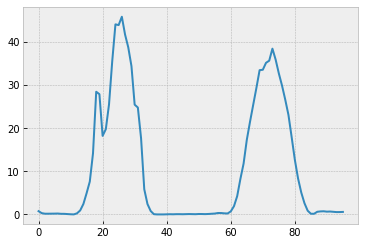

In [ ]:
sub_df['q_0.9'].iloc[:96].plot()

In [ ]:
sub_df.to_csv(path+"seq2seq.csv",index=False)

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>